# Модель предсказания цены ETHUSDT 

**Импорт библиотек**

In [1135]:
import numpy as np
import pandas as pd
from random import seed
from keras import models
from keras import Sequential
import matplotlib.pyplot as plt
from tensorflow.random import set_seed
from keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint
from keras.layers import Dense, LSTM, BatchNormalization
from sklearn.preprocessing import MinMaxScaler


**Импорт данных скрипта parser_klines.ipynb**

In [1136]:
df = pd.read_csv('dataset_klines.csv')
df.set_index('time')

**График исходных данных**

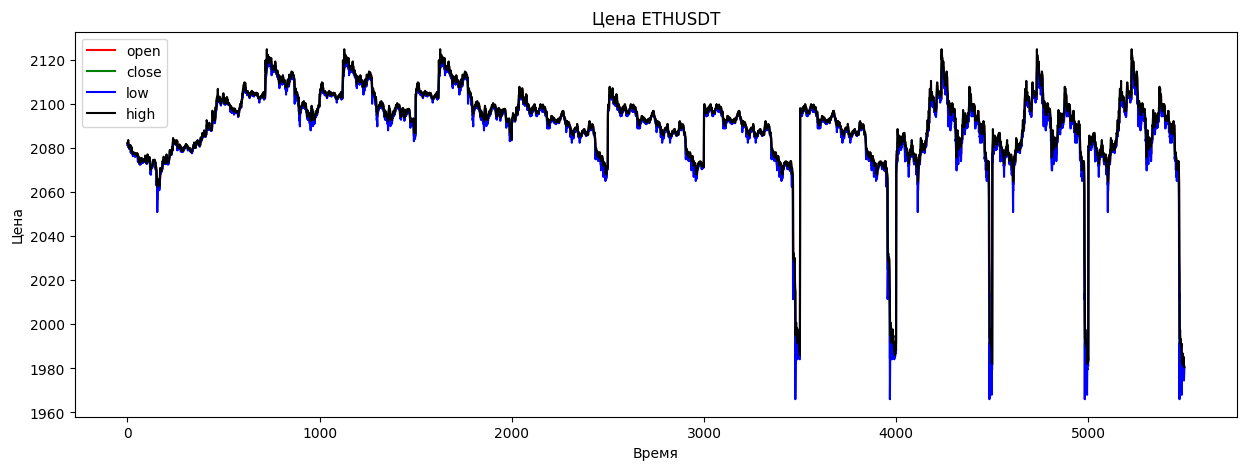

In [1138]:
plt.figure(figsize=(15, 5));
plt.plot(df.open.values, color='red', label='open')
plt.plot(df.close.values, color='green', label='close')
plt.plot(df.low.values, color='blue', label='low')
plt.plot(df.high.values, color='black', label='high')
plt.title('Цена ETHUSDT')
plt.xlabel('Время')
plt.ylabel('Цена')
plt.legend(loc='best')
plt.show()

# Предобработка данных (масштабирование)

In [1139]:
scaler = MinMaxScaler()
open = df[['open']].values
high = df[['high']].values
low = df[['low']].values
close = df[['close']].values

scaler = scaler.fit(open+high+low+close)

df['open'] = scaler.transform(open)
df['high'] = scaler.transform(high)
df['low'] = scaler.transform(low)
df['close'] = scaler.transform(close)


In [ ]:
df.set_index('time',inplace=True)

**График масштабированных данных**

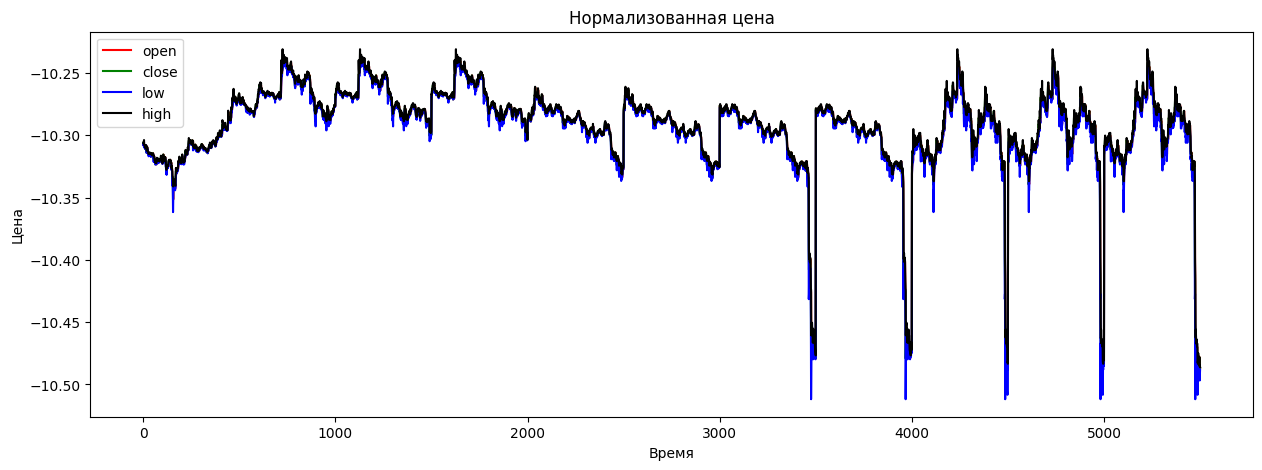

In [1141]:
plt.figure(figsize=(15, 5))
plt.plot(df.open.values, color='red', label='open')
plt.plot(df.close.values, color='green', label='close')
plt.plot(df.low.values, color='blue', label='low')
plt.plot(df.high.values, color='black', label='high')
plt.title('Нормализованная цена')
plt.xlabel('Время')
plt.ylabel('Цена')
plt.legend(loc='best')
plt.show()

# Формирование датасета

In [1142]:
data = df[['open','high','low']]
target = df['close']

In [1143]:
x = []
y = []
timesteps = 10
for i in range(timesteps, len(data)):
# Кодирование даты
  x.append(np.array(data[i-timesteps:i]))
  y.append(target[i])
x, y = np.array(x), np.array(y)

In [1144]:
split = len(data)*85//100
x_train, x_test = x[:split], x[split:]
y_train, y_test = y[:split], y[split:]

# Модель нейросети на LSTM

In [1145]:
model = Sequential()
model.add(LSTM(4, input_shape=(x_train.shape[1], x_train.shape[-1])))
model.add(BatchNormalization())
model.add(Dense(units = 1))


In [1146]:
model.compile(loss = 'mae', optimizer = SGD(learning_rate=0.001),metrics = ['mse'])

In [ ]:
history = model.fit(x_train, y_train, epochs=150, batch_size=32,validation_split=0.1, verbose=2)

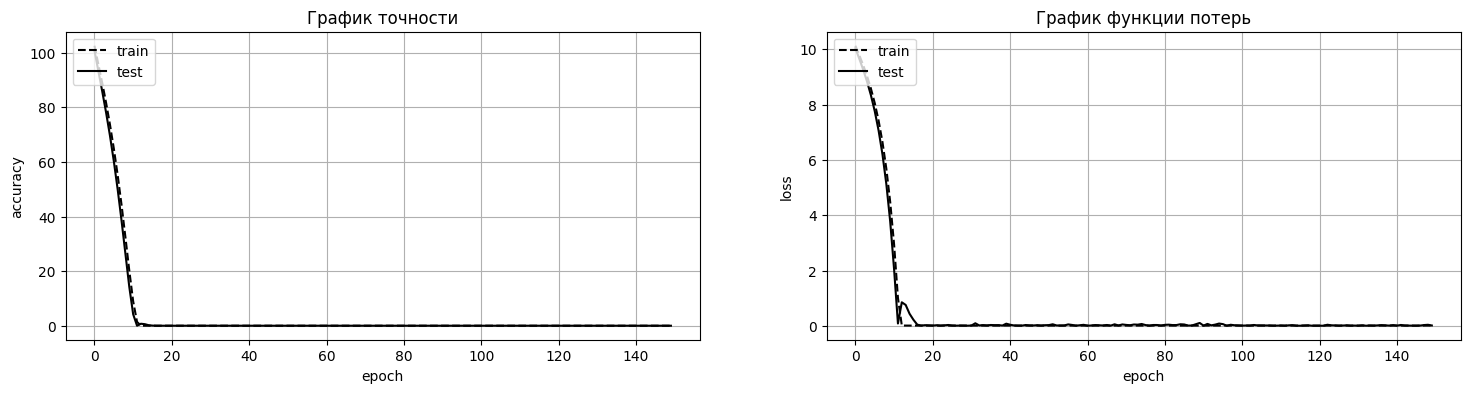

In [1148]:
fig = plt.figure(figsize=(18, 4))

ax = fig.add_subplot(121)
ax.plot(history.history['mse'],'--',color='black')
ax.plot(history.history['val_mse'],color='black')
ax.set_title('График точности')
ax.set_ylabel('accuracy')
ax.set_xlabel('epoch')
ax.legend(['train', 'test'], loc='upper left')
ax.grid(True)
ax2 = fig.add_subplot(122)
ax2.plot(history.history['loss'],'--',color='black')
ax2.plot(history.history['val_loss'],color='black')
ax2.set_title('График функции потерь')
ax2.set_ylabel('loss')
ax2.set_xlabel('epoch')
ax2.legend(['train', 'test'], loc='upper left')
ax2.grid(True)
plt.show()


# Результаты обучения и тестирования модели

**Результаты на обучении**

In [1158]:
test_train = pd.DataFrame()
y_train_pred = list(model.predict(x_train))
test_train['y_train_pred'] = (y_train_pred)
test_train['y_train_real'] = y_train
test_train['отклонение'] = (test_train['y_train_pred'] - test_train['y_train_real'])
test_train['%'] = abs(test_train['отклонение']/test_train['y_train_real'])*100
test_train['y_train_pred'] = test_train['y_train_pred'].str.get(0)
test_train['отклонение'] = test_train['отклонение'].str.get(0)
test_train['%'] = test_train['%'].str.get(0)
test_train.describe()

147/147 [==============================] - 0s 2ms/step


,y_train_pred,y_train_real,отклонение,%
count,4675.000000,4675.000000,4675.000000,4675.000000
mean,-10.277545,-10.291623,0.014077,0.140606
std,0.032114,0.032179,0.006147,0.049667
min,-10.521878,-10.485287,-0.177130,0.005810
25%,-10.291534,-10.304827,0.013013,0.126835
50%,-10.272843,-10.287242,0.014455,0.140636
75%,-10.261240,-10.275047,0.015738,0.153231
max,-10.224329,-10.238817,0.061211,1.723287


**Результаты на тестовой выборке**

In [1160]:
test_test = pd.DataFrame()

y_test_pred = (model.predict(x_test))
test_test['y_test_pred'] = list(y_test_pred)
test_test['y_test_real'] = (y_test)
test_test['отклонение'] = (test_test['y_test_pred'] - test_test['y_test_real'])
test_test['%'] = abs(test_test['отклонение']/test_test['y_test_real'])*100
test_test['y_test_pred'] = test_test['y_test_pred'].str.get(0)
test_test['отклонение'] = test_test['отклонение'].str.get(0)
test_test['%'] = test_test['%'].str.get(0)

test_test.describe()

26/26 [==============================] - 0s 2ms/step


,y_test_pred,y_test_real,отклонение,%
count,815.000000,815.000000,815.000000,815.000000
mean,-10.288260,-10.301695,0.013434,0.139734
std,0.046711,0.047552,0.010243,0.084791
min,-10.512803,-10.487549,-0.149669,0.000139
25%,-10.297854,-10.310447,0.010208,0.100463
50%,-10.278667,-10.291094,0.013706,0.133667
75%,-10.263794,-10.278025,0.016633,0.161741
max,-10.227907,-10.241009,0.061211,1.451328


**Графики реальных и предсказанных значений**


correct sign prediction for close - open price for train/valid/test: 1.00/0.00


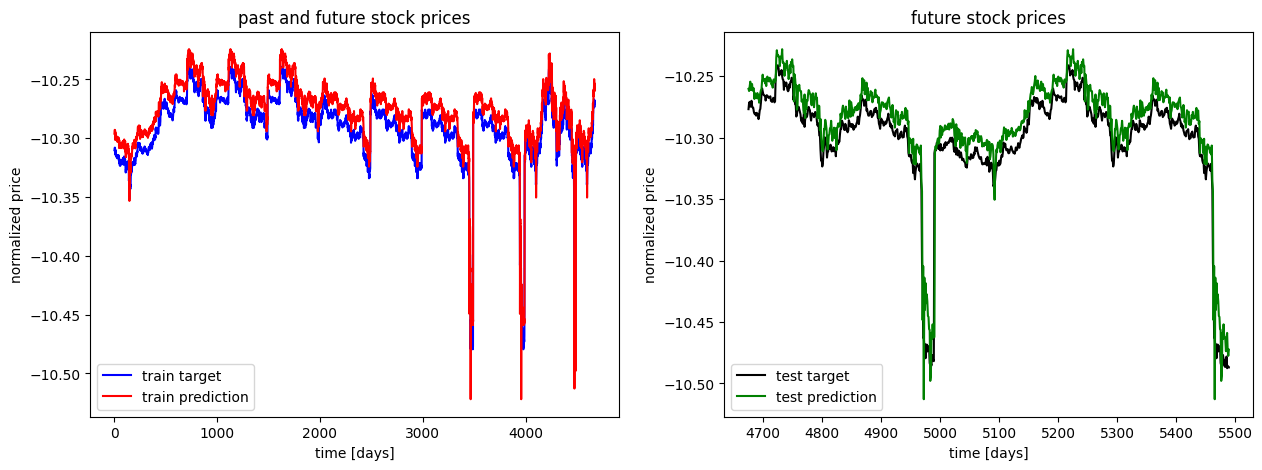

In [1154]:
ft = 0 # 0 = open, 1 = close, 2 = highest, 3 = lowest

## show predictions
plt.figure(figsize=(15, 5))
plt.subplot(1,2,1)

plt.plot(np.arange(y_train.reshape(-1,1).shape[0]), y_train.reshape(-1,1)[:,ft], color='blue', label='train target')

plt.plot(np.arange(y_train_pred.reshape(-1,1).shape[0]),y_train_pred.reshape(-1,1)[:,ft], color='red',
         label='train prediction')



plt.title('past and future stock prices')
plt.xlabel('time [days]')
plt.ylabel('normalized price')
plt.legend(loc='best')

plt.subplot(1,2,2)

plt.plot(np.arange(y_train.reshape(-1,1).shape[0], y_train.reshape(-1,1).shape[0]+y_test.reshape(-1,1).shape[0]),y_test.reshape(-1,1)[:,ft], color='black', label='test target')

plt.plot(np.arange(y_train_pred.reshape(-1,1).shape[0],
                    y_train_pred.reshape(-1,1).shape[0]+y_test_pred.reshape(-1,1).shape[0]),
         y_test_pred.reshape(-1,1)[:,ft], color='green', label='test prediction')

plt.title('future stock prices')
plt.xlabel('time [days]')
plt.ylabel('normalized price')
plt.legend(loc='best')

corr_price_development_train = np.sum(np.equal(np.sign(y_train.reshape(1,-1)[:,1]-y_train.reshape(1,-1)[:,0]),
            np.sign(y_train_pred.reshape(1,-1)[:,1]-y_train_pred.reshape(1,-1)[:,0])).astype(int)) / y_train.reshape(1,-1).shape[0]

corr_price_development_test = np.sum(np.equal(np.sign(y_test.reshape(1,-1)[:,1]-y_test.reshape(1,-1)[:,0]),
            np.sign(y_test_pred.reshape(1,-1)[:,1]-y_test_pred.reshape(1,-1)[:,0])).astype(int)) / y_test.reshape(1,-1).shape[0]

print('correct sign prediction for close - open price for train/valid/test: %.2f/%.2f'%(
    corr_price_development_train, corr_price_development_test))